# Hands On Long Term, Mid Term and Short Term Forecasting with Polynomial Regression, AutoARIMA and TimeGPT-1

**Forecasting is a set of computational techniques aimed at predicting future values of a time series based on historical patterns**.
However, the choice of techniques, evaluation metrics, and data requirements depends heavily on how far into the future we're trying to forecast.

For example, if we want to know **how hot it will be in New York over the next three years (long term forecasting)**, we probably don't need, nor would it be helpful, to have minute-level time series data. The dataset will be noisy and it will "distract" the algorithm from the big picture. Instead, it would be far more useful to have NYC weather records from, say, 1925 to 2025, to predict what might happen in 2026, 2027, and 2028.

On the other hand, if we're dealing **with finance and need to predict a stock price over the next hour**, very granular data (e.g., updates every minute) becomes crucial (**short term forecasting**). Here, the rapid variactions are far from being just "noise". Actually, such granular data enables the algorithm to capture the subtle and rapid fluctuations of the market.

There is also a grey area. For example, if we are trying to **forecast electricity demand in a city for the next few weeks (mid term forecasting)**, we don’t need minute-by-minute data, but we also can’t rely only on yearly averages. In that case, daily data from the past few months would strike a good balance, as they capture both seasonal trends and recent shifts in consumption patterns.

The algorithms suited for long-term, mid-term, and short-term forecasting are often quite different. Each task benefits from models that are tailored to its specific time horizon and data characteristics. In this blog post, we'll walk through a single forecasting problem and tackle it using three different approaches: one for long term forecasting, one for mid term forecasting, and one for short term forecasting. 


## Different Terms Forecasting Algorithm
Given a raw time series, the forecasting strategy depends on the time horizon we're targeting.
To handle long-term, mid-term, and short-term forecasts effectively, we can follow this structured approach:
* Start with the raw time series.
* Aggregate the data based on the desired time horizon (long, mid, short)
* Apply a forecasting model suited to that level of aggregation to generate future estimates.

![image](images/diagram.svg)

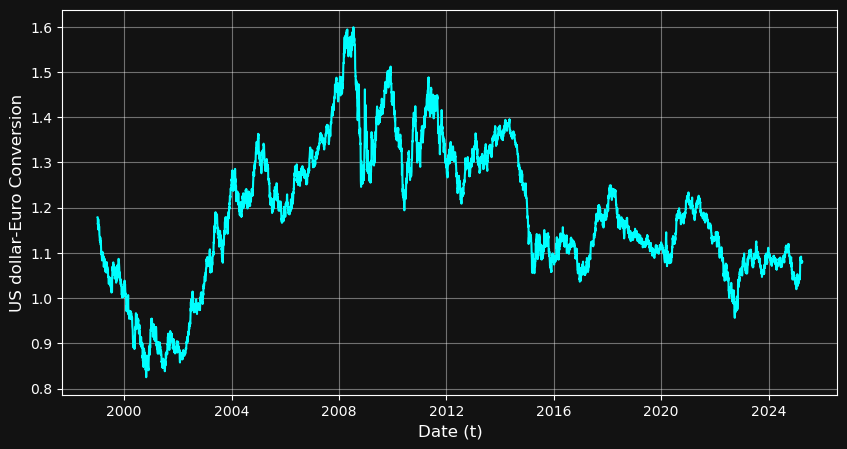

In [1]:
import numpy as np 
import pandas as pd 
from plotter import * 
from utils import * 

data = pd.read_csv('data/euro_conversion_data.csv')
plot_timeseries(data)

In [2]:
keys = ['year','month','day']
key_dict = {key: aggregate_data(data, key = key) for key in keys}

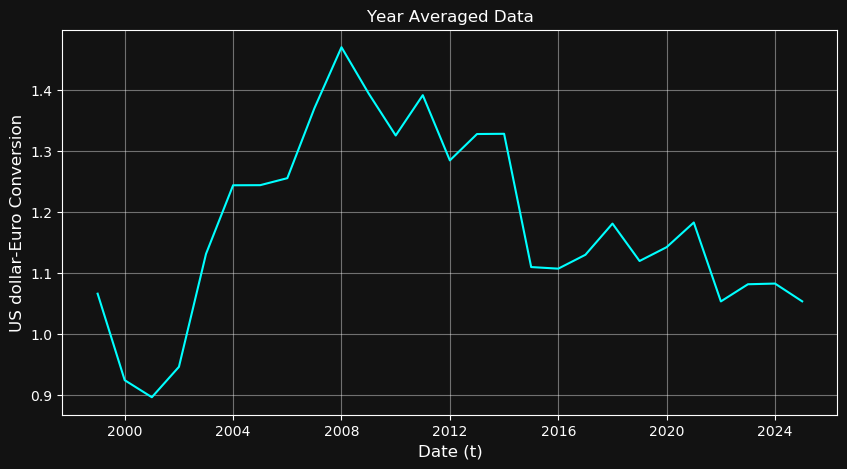

In [3]:

plot_timeseries(key_dict['year'], date_column = 'time_group', title = 'Year Averaged Data')

Degree 1 - Val MSE: 0.0407
Degree 2 - Val MSE: 0.0168
Degree 3 - Val MSE: 0.0006
Degree 4 - Val MSE: 0.2123
Degree 5 - Val MSE: 0.0083


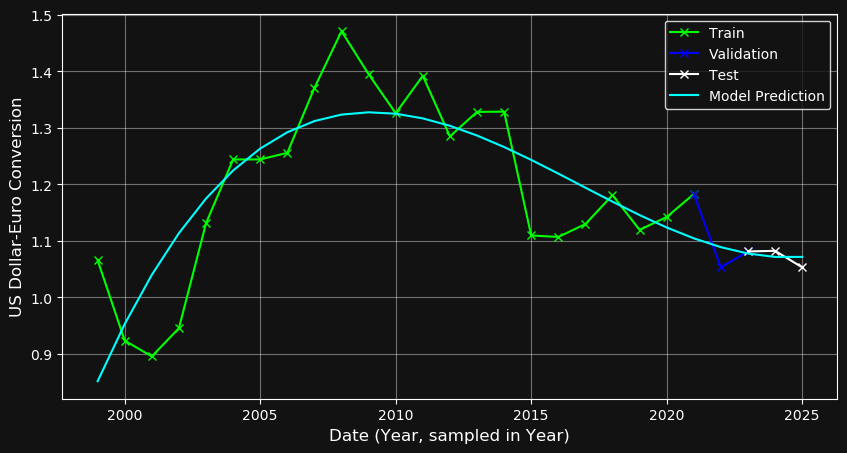

In [320]:
from models import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

from constants import * 

# Declare Dataset
y = np.array(key_dict['year']['US dollar'])
x_full = np.arange(0, len(y)).reshape(-1, 1)

# Model fitting
train, val, test = split_timeseries(y)
model_tuple, best_degree = polynomial_fit_and_select(train, val)
poly = PolynomialFeatures(degree = best_degree).fit(x_full)
X_test_poly = poly.transform(x_full)
y_full_pred = model_tuple[0].predict(X_test_poly)
train_index = len(train)
val_index = len(val)
test_index = len(test)
# Plotting
x_full = x_full + 1999
plt.figure(figsize = IMAGE_FIGSIZE)
plt.plot(x_full[0:train_index], y[:train_index], label='Train', color = 'lime', marker ='x')
plt.plot(x_full[train_index-1:train_index+val_index], y[train_index-1:train_index+val_index], label='Validation', color = 'blue', marker = 'x')
plt.plot(x_full[train_index+val_index-1:], y[train_index+val_index-1:], label='Test', color = 'white', marker = 'x')
plt.plot(x_full, y_full_pred, color = 'cyan', label = 'Model Prediction')
plt.xlabel('Date (Year, sampled in Year)', fontsize = 12)
plt.ylabel('US Dollar-Euro Conversion', fontsize = 12)
plt.legend()
plt.savefig('images/year_prediction.svg')
plt.show()




In [321]:
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
df = key_dict['month']
x_full = np.arange(0, len(y)).reshape(-1, 1)
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
Y_train_df = df[(df.ds>='2023-12-01') & (df.ds<='2024-12-01')] 
Y_test_df = df[df.ds>='2024-12-01']
season_length = 4 # Monthly data 
horizon = len(Y_test_df)+1 # number of predictions
models = [AutoARIMA(season_length=season_length)]
sf = StatsForecast(models=models, freq='MS')
sf.fit(df=Y_train_df)
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon, fitted=True)
Y_hat_df.head()
values=sf.forecast_fitted_values()
values

,unique_id,ds,y,AutoARIMA
0,1,2024-01-01,1.090514,1.082714
1,1,2024-02-01,1.079471,1.085175
2,1,2024-03-01,1.087220,1.078573
3,1,2024-04-01,1.072776,1.086325
4,1,2024-05-01,1.081223,1.073990
5,1,2024-06-01,1.075900,1.085623
6,1,2024-07-01,1.084409,1.076109
7,1,2024-08-01,1.101218,1.086230
8,1,2024-09-01,1.110600,1.089987
9,1,2024-10-01,1.090435,1.093146


In [322]:
Y_test_pred = sf.forecast(df=Y_train_df, h=4, level=[95])
Y_test_pred

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,1,2025-01-01,1.068015,1.039636,1.096393
1,1,2025-02-01,1.081567,1.049018,1.114117
2,1,2025-03-01,1.081567,1.049018,1.114117
3,1,2025-04-01,1.081567,1.049018,1.114117


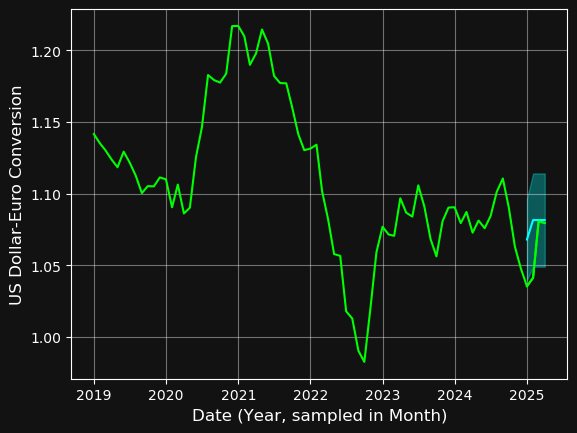

In [323]:
x_full = np.array(pd.to_datetime(df['ds']))
y_full = np.array(df['y'])
x_test = np.array(pd.to_datetime(Y_test_df['ds']))
y_test = np.array(Y_test_df['y'])
y_pred_test = np.array(Y_test_pred['AutoARIMA'])
lower_bound = np.array(Y_test_pred['AutoARIMA-lo-95'])
upper_bound = np.array(Y_test_pred['AutoARIMA-hi-95'])
x_pred_test =  np.array(Y_test_pred['ds'])
plt.plot(x_full[240:], y_full[240:], color = 'lime', label = '')
plt.plot(x_pred_test, y_pred_test, color ='cyan', label = 'AutoARIMA prediction')
plt.fill_between(x_pred_test, lower_bound, upper_bound, color = 'cyan', alpha = 0.3, label = 'AutoARIMA 95p boundaries')
plt.plot(x_test, y_test, color = 'lime', label = 'Test Set Data')
plt.xlabel('Date (Year, sampled in Month)', fontsize = 12)
plt.ylabel('US Dollar-Euro Conversion',fontsize = 12 )
plt.savefig('images/month_prediction.svg')

In [325]:
from nixtla import NixtlaClient
keys = ['year','month','day']
key_dict = {key: aggregate_data(data, key = key) for key in keys}
df = key_dict['day']
df = df.rename(columns = {'time_group': 'ds'})
df = df[df.ds >= '2024-01-01']
df = df.reset_index().drop('index', axis  = 1)
x_full = np.arange(0, len(y)).reshape(-1, 1)
df["unique_id"]="1"
timestamps = pd.date_range(start='2024-01-01', periods=len(df), freq='D')
df['ds'] = timestamps
df.columns=["ds", "y", "unique_id"]
Y_train_df = df[(df.ds <= '2024-11-09') & (df.ds >= '2024-01-01')] 
Y_test_df = df[df.ds >= '2024-11-09']
test = Y_test_df
input_seq = Y_train_df
api_key = "nixak-RQfnGSr1FwWorgIytsluk2SnybiDME3feGIa4HFdVdNQTAleW5cbwBC7hTSg5DDjTscMo42tkSk8bA9V"
nixtla_client = NixtlaClient(api_key=api_key)
fcst_df = nixtla_client.forecast(
    df=input_seq,
    h=10,
    level=[75],
    finetune_steps=3,
    finetune_loss='mae',
    model='timegpt-1',
    time_col='ds',
    target_col='y'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


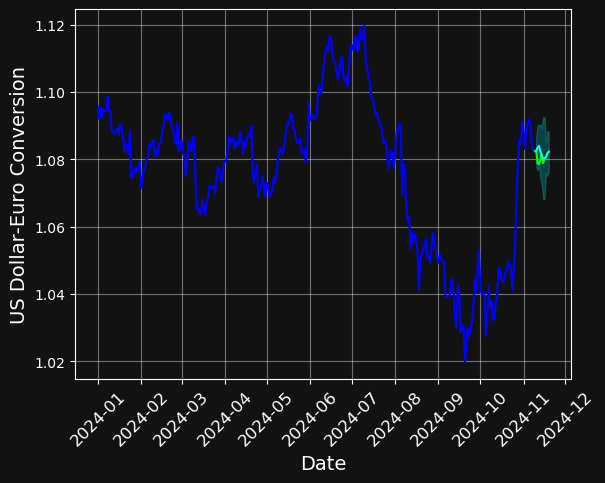

In [326]:
plt.plot(np.array(pd.to_datetime(Y_train_df['ds'])), np.array(Y_train_df['y']), color = 'blue')
plt.plot(np.array(pd.to_datetime(Y_test_df['ds'])), np.array(Y_test_df['y']), color = 'lime')
plt.plot(np.array(pd.to_datetime(np.array(fcst_df['ds']))), np.array(fcst_df['TimeGPT']), color = 'cyan')
plt.fill_between(np.array(pd.to_datetime(np.array(fcst_df['ds']))), np.array(fcst_df['TimeGPT-lo-75']), np.array(fcst_df['TimeGPT-hi-75']), color = 'cyan', alpha = 0.2)
plt.xticks(fontsize = 12, rotation = 45)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('US Dollar-Euro Conversion', fontsize = 14)
plt.savefig('images/day_prediction.svg')